In [1]:
from rdflib import Graph
import matplotlib.pyplot as plt
import pandas as pd
import math

### Load Tretament Graphs

In [2]:
g = Graph()
g.parse('../KG/'+name+'/LungCancer.nt', format="nt")

<Graph identifier=Nc7dfb34455e14452a793b78de166563b (<class 'rdflib.graph.Graph'>)>

In [3]:
from rdflib.plugins.sparql.processor import SPARQLResult

def sparql_results_to_df(results: SPARQLResult) -> pd.DataFrame:
    """
    Export results from an rdflib SPARQL query into a `pandas.DataFrame`,
    using Python types. See https://github.com/RDFLib/rdflib/issues/1179.
    """
    return pd.DataFrame(
        data=([None if x is None else x.toPython() for x in row] for row in results),
        columns=[str(x) for x in results.vars],
    )

In [4]:
def cardinality_relation(graph, relation):
    query = """
    select (count(?s) as ?count)
    where {
        ?s <""" + relation + """> ?o
        }
        """
    qres = graph.query(query)
    cardinality = sparql_results_to_df(qres)
    return cardinality.iloc[0][0]


def cardinality_entity(graph, entity):
    query = """
    select (count(?s) as ?count)
    where {
        ?s ?p <""" + entity + """>
        }
        """
    qres = graph.query(query)
    cardinality = sparql_results_to_df(qres).iloc[0][0]
    
    query = """
    select (count(?o) as ?count)
    where {
        <""" + entity + """> ?p ?o
        }
        """
    qres = graph.query(query)
    cardinality += sparql_results_to_df(qres).iloc[0][0]
    return cardinality


def probability_relation(graph, r):
    cardinality  = cardinality_relation(graph, r)
    return cardinality / len(graph)


def probability_entity(graph, e):
    cardinality  = cardinality_entity(graph, e)
    return cardinality / len(graph)


def get_triples(graph):
    query = """    
    select distinct ?s ?predicate ?object
    where {
        ?s ?predicate ?object
        }
        """
    qres = graph.query(query)
    triples = sparql_results_to_df(qres)
    return triples


def list_relation(triples):
    return list(triples.predicate.unique())


def list_entity(triples):
    entity = set(list(triples.s.unique()) + list(triples.object.unique()))
    return entity


def relation_entropy(graph, relation):
    RE = 0
    for r in relation:
        p_r = probability_relation(graph, r)
        val = -p_r*math.log(p_r)
        RE += val
    return RE


def entity_entropy(graph, entity):
    EE = 0
    for e in entity:
        p_e = probability_entity(graph, e)
        val = -p_e*math.log(p_e)
        EE += val
    return EE


def relational_density(graph, relation):
    return len(graph) / len(relation)


def entity_density(graph, entity):
    return 2 * len(graph) / len(entity)

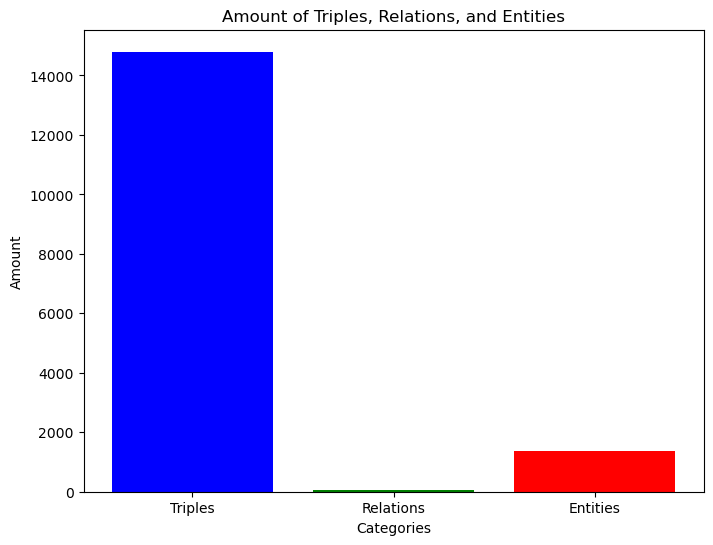

In [12]:
def plot_statistics(name):
    g = Graph()
    g.parse('../KG/'+name+'/LungCancer.nt', format="nt")
    triples = get_triples(g)
    relation = list_relation(triples)
    entity = list_entity(triples)
    categories = ['Triples', 'Relations', 'Entities']
    values = [triples.shape[0], len(relation), len(entity)]

    plt.figure(figsize=(8, 6))
    plt.bar(categories, values, color=['blue', 'green', 'red'])
#     plt.xlabel('Categories')
    plt.ylabel('Amount')
    plt.title('Statistics of '+name)
    plt.show()